In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext
import pyspark.sql.functions as f
from pyspark.sql.functions import col,avg
from pyspark.sql.types import StructType, StructField, StringType, FloatType
import numpy as np
import matplotlib.pyplot as plt

sc = SparkContext()
sqlContext=SQLContext(sc)

sdf = sqlContext.read.csv("./data/tracks_features.csv", header=True, inferSchema=True)
pldf = sqlContext.read.csv("./data/playlists.csv",header=True, inferSchema=True)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/01/28 20:06:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/01/28 20:06:18 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


/Users/erka/opt/anaconda3/envs/spotify/lib/python3.11/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Preprocessing: 
* Remove Nan values (unsuccessfully parsed entries) 
* Rename columns consistently
* separate comma-separated artists --> give each artist-song combination one entry
* remove entries with nonsensical release-year 
* cast numeric columns to correct type

In [2]:
pldf = pldf.dropna() #12902577 --> 12868945
sdf = sdf.dropna()

pldf = pldf.withColumnRenamed(' "artistname"',"artist") \
    .withColumnRenamed("user_id","user") \
    .withColumnRenamed(' "trackname"',"track") \
    .withColumnRenamed(' "playlistname"',"playlist")

sdf = sdf.drop("artist_ids", "album_id") \
    .withColumnRenamed("artists","artist") \
    .withColumnRenamed("name","track")
sdf = sdf.withColumn("artist", f.split(col("artist"), ",")) \
        .withColumn("artist", f.explode(col("artist"))) \
        .withColumn("artist",f.trim(col("artist"))) \
        .withColumn("artist", f.translate(col("artist"),"[]\"'",""))
sdf= sdf.withColumn("year", f.trim(col("year"))) \
                  .withColumn("year", col("year").cast("integer")) \
                  .where(~f.isnull(col("year")))
sdf = sdf.where((col("year") >= 1800) & (col("year") <= 2022)) # years that make no sense
sdf = sdf.orderBy(f.desc("year"))


#set correct datatypes
columns_to_cast = ["danceability", "energy", "key", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]
for column in columns_to_cast:
    sdf = sdf.withColumn(column, col(column).cast("float"))

Join both datasets on the name of the artist and the track

In [3]:
merge_df = pldf.join(sdf, on = ["artist","track"],how = "left") # 13918877 entries
merge_df = merge_df.dropna().persist() #2727713 entries

In [4]:
merge_df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- track: string (nullable = true)
 |-- user: string (nullable = true)
 |-- playlist: string (nullable = true)
 |-- id: string (nullable = true)
 |-- album: string (nullable = true)
 |-- track_number: string (nullable = true)
 |-- disc_number: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- danceability: float (nullable = true)
 |-- energy: float (nullable = true)
 |-- key: float (nullable = true)
 |-- loudness: float (nullable = true)
 |-- mode: float (nullable = true)
 |-- speechiness: float (nullable = true)
 |-- acousticness: float (nullable = true)
 |-- instrumentalness: float (nullable = true)
 |-- liveness: float (nullable = true)
 |-- valence: float (nullable = true)
 |-- tempo: float (nullable = true)
 |-- duration_ms: float (nullable = true)
 |-- time_signature: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- release_date: string (nullable = true)



Calculate some general statistics

In [5]:
num_tracks = merge_df.select("track").distinct().count()
num_artists = merge_df.select("artist").distinct().count()
num_rows = merge_df.count()
print(num_tracks,num_artists,num_rows)

147280 19732 2726346


In [6]:
print("# tracks in playlist df:", pldf.select("track","artist").distinct().count())
print("# playlists in playlist df:", pldf.select("playlist").distinct().count())
print("# artists in playlist df:", pldf.select("artist").distinct().count())
print("# tracks in song df:", sdf.select("id").distinct().count())
print("# artists in song df:", sdf.select("artist").distinct().count())
print("# tracks in merge df:", merge_df.select("id").distinct().count())

# tracks in playlist df: 2795058


# playlists in playlist df: 161327


# artists in playlist df: 289810


# tracks in song df: 1193595


# artists in song df: 135481


# tracks in merge df: 209644


Attributes that we want to analyse in the following section

In [7]:
attr_names = ["danceability", "energy", "loudness", "mode", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "duration_ms", "time_signature"]

### Attributes over time
* averages, min, max, stddev over years
* operations: group by year, aggregate and order

In [8]:
grouped = sdf.groupBy("year")
count_year=grouped.count().orderBy(f.asc("year"))
sdf_avg = grouped \
    .avg(*attr_names) \
    .orderBy(f.asc("year"))
sdf_max = grouped \
    .max(*attr_names) \
    .orderBy(f.asc("year"))
sdf_min = grouped \
    .min(*attr_names) \
    .orderBy(f.asc("year"))
sdf_var = grouped \
    .agg({a:"variance" for a in attr_names}) \
    .orderBy(f.asc("year"))

Plot number of available songs for each year

<BarContainer object of 100 artists>

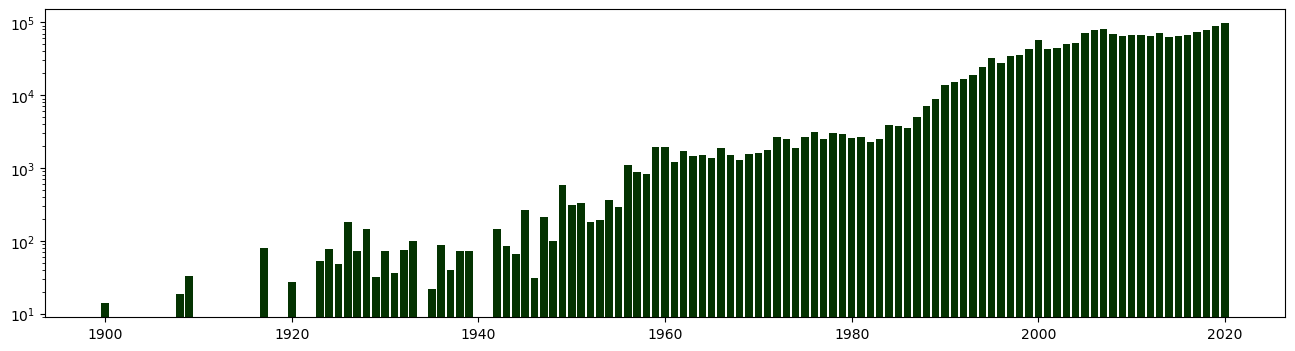

In [9]:
pt = count_year.toPandas()
figure = plt.figure(figsize=(16, 4))#, sharey=True)
plt.yscale("log")
plt.bar(pt["year"], pt["count"], color = '#043301')

### Popularity
What are the most popular artists and songs? 
Popularity := how many distinct playlists a song/artist is included in

* add column for song popularity (how many distinct playlists song is in)
* add column for artist popularity (how many distinct playlists artist is in)
* calculate popularity over years by averaging song popularity score for every song released in the same year
* averages, min, max, stddev for top 100 most popular artists (after averaging song attributes for top 100 artists)
* averages, min, max, stddev for top 100 most popular songs

In [10]:
# calculate popularity scores
artist_popularity = merge_df.select("artist", "playlist") \
    .distinct() \
    .groupBy("artist") \
    .count() \
    .orderBy(f.desc("count"))
song_popularity = merge_df.select("track", "artist", "playlist") \
    .distinct() \
    .groupBy(["track", "artist"]) \
    .count() \
    .orderBy(f.desc("count"))

# remove playlist columns that are not needed anymore
songs = merge_df.select(*(["artist","track","year"]+attr_names)).distinct()

# append scores to dataframe
songs_pop = songs.join(artist_popularity, on="artist", how="left") \
    .withColumnRenamed("count", "artist_popularity")
songs_pop = songs_pop.join(song_popularity, on=["track", "artist"], how="left") \
    .withColumnRenamed("count", "song_popularity")

#get popularity over time
pop_time = songs_pop.groupBy("year").avg("song_popularity").orderBy(f.asc("year"))

# average attributes over each artist songs
avg_art_group = songs_pop.groupBy("artist") \
    .avg(*(attr_names + ["artist_popularity"])) \
    .orderBy(f.desc("avg(artist_popularity)")) \
    .groupBy() 
# get average, min, max, stddev for all artists
avg_art_avg = avg_art_group.avg(*[f"avg({a})" for a in attr_names])
avg_art_min = avg_art_group.min(*[f"avg({a})" for a in attr_names])
avg_art_max = avg_art_group.max(*[f"avg({a})" for a in attr_names])
avg_art_var = avg_art_group.agg(*[f.variance(col) for col in [f"avg({a})" for a in attr_names]])

# average over each artist songs, get top 100 most popular artists
pop_art_group = songs_pop.groupBy("artist") \
    .avg(*(attr_names + ["artist_popularity"])) \
    .orderBy(f.desc("avg(artist_popularity)")) \
    .limit(100) \
    .groupBy() 
# get average, min, max, stddev for most popular artists
pop_art_avg = pop_art_group.avg(*[f"avg({a})" for a in attr_names])
pop_art_min = pop_art_group.min(*[f"avg({a})" for a in attr_names])
pop_art_max = pop_art_group.max(*[f"avg({a})" for a in attr_names])
pop_art_var = pop_art_group.agg(*[f.variance(col) for col in [f"avg({a})" for a in attr_names]])

# get average, min, max, stddev for all songs
song_avg = songs_pop.groupBy().avg(*attr_names)
song_min = songs_pop.groupBy().min(*attr_names)
song_max = songs_pop.groupBy().max(*attr_names)
song_var = songs_pop.agg(*[f.variance(col) for col in attr_names])

#get top 100 most popular songs
pop_avg_group = songs_pop.orderBy(f.desc("song_popularity")) \
    .limit(100) \
    .groupBy()
# get average, min, max, stddev for top songs
pop_avg = pop_avg_group.avg(*attr_names)
pop_max = pop_avg_group.max(*attr_names)
pop_min = pop_avg_group.min(*attr_names)
pop_var = pop_avg_group.agg(*[f.variance(col) for col in attr_names])

Plot development of song popularity over years

<BarContainer object of 100 artists>

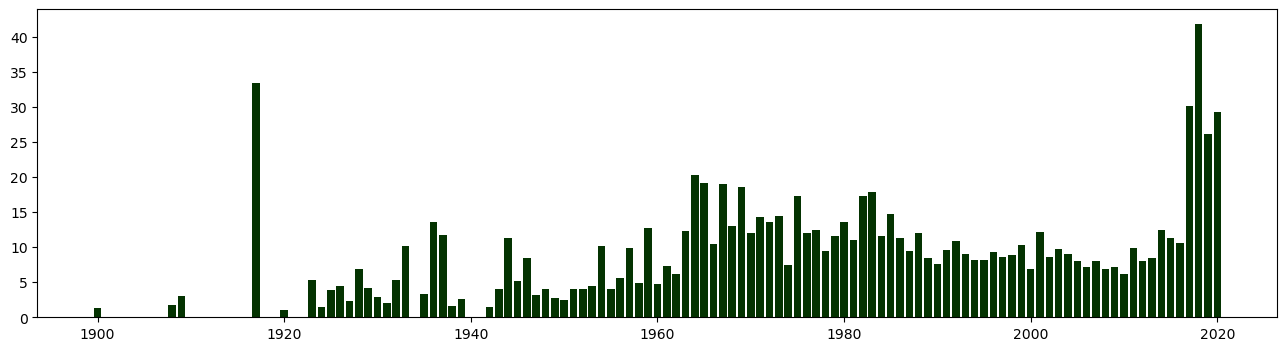

In [11]:
pt = pop_time.toPandas()
figure = plt.figure(figsize=(16, 4))#, sharey=True)
plt.bar(pt["year"], pt["avg(song_popularity)"], color = '#043301')

In [12]:
print(song_popularity.toPandas().head(10))
print(artist_popularity.toPandas().head(10))

                           track           artist  count
0                         Ho Hey    The Lumineers   1547
1                           Kids             MGMT   1319
2  Rather Be (feat. Jess Glynne)     Clean Bandit   1279
3               Do I Wanna Know?   Arctic Monkeys   1204
4                     Chandelier              Sia   1169
5           Don't Stop Believin'          Journey   1114
6                           Sail       AWOLNATION   1110
7                    Take Me Out  Franz Ferdinand   1084
8                          Creep        Radiohead   1066
9                         Summer    Calvin Harris   1058


              artist  count
0            Beyoncé   3476
1          Radiohead   3406
2     Arctic Monkeys   3038
3           Coldplay   2855
4    Michael Jackson   2593
5               MGMT   2516
6          Bob Dylan   2307
7       Foo Fighters   2212
8        The Strokes   2189
9  Bruce Springsteen   2131


In [13]:
# get num of unique artists
merge_df.select('artist').distinct().count()#.show()

19732

In [14]:
# most songs per artist
merge_df.select("artist", "track").distinct().groupBy("artist").count().orderBy(f.desc("count")).toPandas().head(10)

,artist,count
0,Johann Sebastian Bach,1565
1,Vitamin String Quartet,1128
2,Wolfgang Amadeus Mozart,411
3,Guided By Voices,393
4,Rockabye Baby!,333
5,Ludwig van Beethoven,333
6,Bob Dylan,325
7,Claude Debussy,321
8,Aretha Franklin,298
9,Robert Pollard,277


In [15]:
# get avg song duration
merge_df.agg(avg('duration_ms')).toPandas().head(10)

,avg(duration_ms)
0,246347.991325


In [16]:
# get num of minor/major songs
merge_df.groupBy('mode').count().toPandas().head()

,mode,count
0,1.0,1905292
1,0.0,821054


In [17]:
# get num of explicit songs
merge_df.groupBy('explicit').count().toPandas().head()

,explicit,count
0,False,2594936
1,True,131410


In [18]:
# get num of songs in diff keys
merge_df.groupBy('key').count().orderBy(f.asc("key")).toPandas().head(20)

,key,count
0,0.0,361396
1,1.0,206227
2,2.0,297276
3,3.0,72837
4,4.0,254970
5,5.0,218901
6,6.0,190787
7,7.0,319640
8,8.0,145228
9,9.0,296657


### Visualization of Attributes over the Years

In [19]:
time_pandas = sdf_avg.toPandas()
time_pandas_max = sdf_max.toPandas()
time_pandas_min = sdf_min.toPandas()
time_pandas_var = sdf_var.toPandas()
entries = len(time_pandas_var)

data = attr_names

23/01/28 20:07:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:56 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:57 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:57 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/28 20:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/28 20:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:58 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:07:58 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/28 20:07:59 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/28 20:08:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


23/01/28 20:08:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:08 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/28 20:08:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:09 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


23/01/28 20:08:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:10 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:10 WARN RowBasedKeyValueBatch: Calling spill() on

23/01/28 20:08:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
23/01/28 20:08:11 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


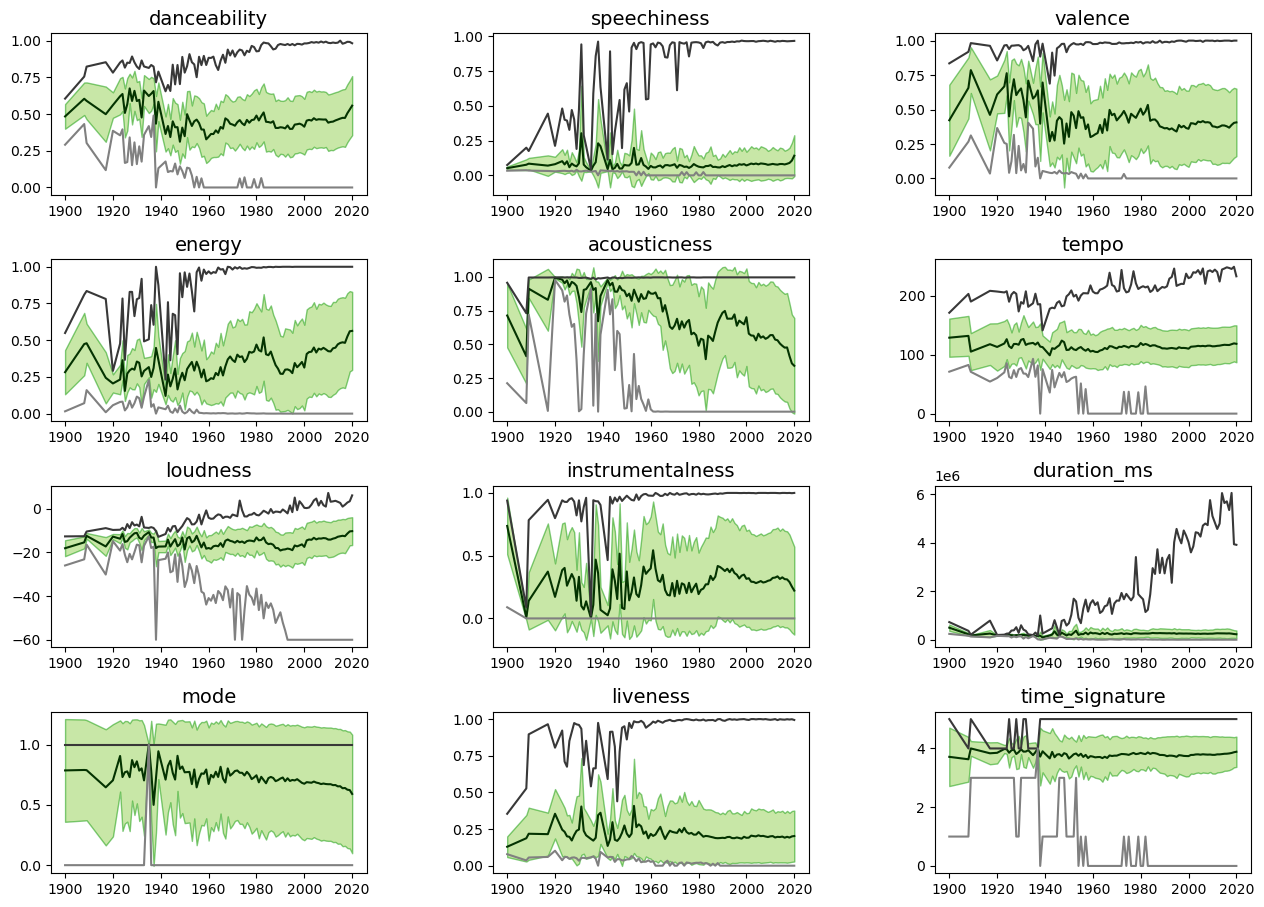

In [20]:
import matplotlib.pyplot as plt
import numpy as np
time_yticks = time_pandas_var["year"]

# Create a figure with 3 rows and 3 columns of subplots
fig, ax = plt.subplots(4, 3,figsize=(20, 14))

# Iterate over the data series and plot each one in the corresponding subplot
for i in range(3):
    for j in range(4):
        if i*4+j>=len(data):
            break
        data_series = data[i*4+j]
        average = time_pandas[f"avg({data_series})"]
        ax[j,i].plot(time_yticks, average, color = '#043301')
        ax[j,i].plot(time_yticks, time_pandas_max[f"max({data_series})"], color = '#383838')
        ax[j,i].plot(time_yticks, time_pandas_min[f"min({data_series})"], color = '#808080')
        stddv = np.sqrt(time_pandas_var[f"variance({data_series})"])
        ax[j,i].fill_between(time_yticks,average-stddv,average+stddv,alpha=0.5, edgecolor='#0d9903', facecolor='#92D050')
        ax[j,i].set_title(data_series, fontsize = 14)

# Show the figure
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.7,
                    top=0.7,
                     wspace=0.4,
                    hspace=0.4)
plt.show()

### Visualization of Attributes for popular song vs. average song

In [21]:
# prepare stats of popular music as numpy array
min_attr_pop = np.array(pop_min.toPandas().iloc[0])
average_attr_pop = np.array(pop_avg.toPandas().iloc[0])-min_attr_pop
max_attr_pop = np.array(pop_max.toPandas().iloc[0])-min_attr_pop
std_attr_pop = np.sqrt(np.array(pop_var.toPandas().iloc[0]))

# prepare stats of all music as numpy array
min_attr = np.array(song_min.toPandas().iloc[0])
average_attr = np.array(song_avg.toPandas().iloc[0])-min_attr
max_attr = np.array(song_max.toPandas().iloc[0])-min_attr
std_attr = np.sqrt(np.array(song_var.toPandas().iloc[0]))

# scale stats according to global max and min (range of values of each attribute)
max_std_g = np.maximum(std_attr,std_attr_pop)
avg_attr = average_attr/max_attr
avg_attr_pop = average_attr_pop/max_attr
std_attr = std_attr/max_attr
std_attr_pop = (std_attr_pop/max_attr)

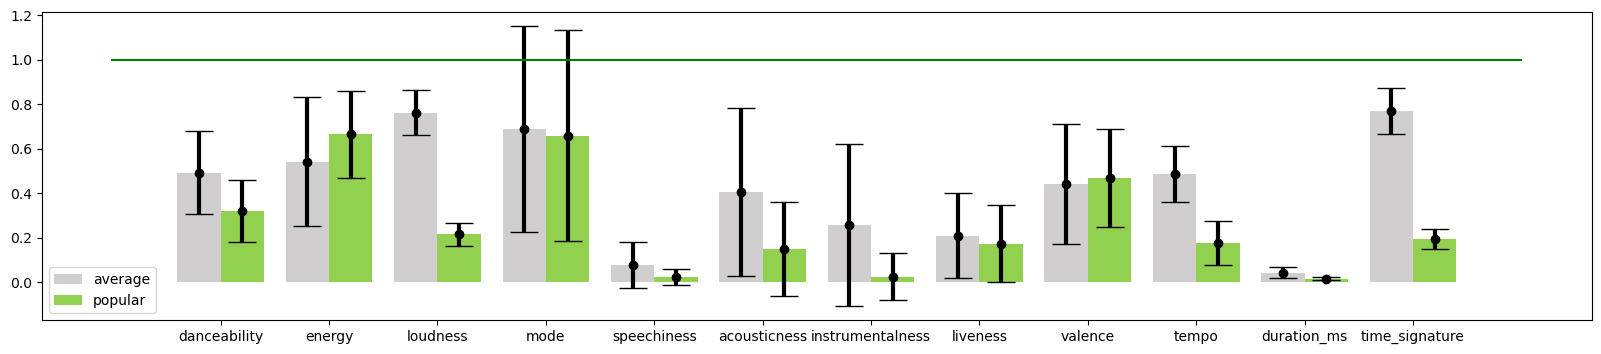

In [22]:
# plot data: average song vs popular song
data=attr_names
X_axis = np.arange(len(data))
figure = plt.figure(figsize=(20, 4))#, sharey=True)
plt.bar(X_axis - 0.2, avg_attr, 0.4, label = 'average', color = '#D0CECE')
plt.bar(X_axis + 0.2, avg_attr_pop, 0.4, label = 'popular', color = '#92D050')
  
plt.errorbar(X_axis-0.2, avg_attr, yerr=std_attr, fmt='o', color='black',
             ecolor='black', elinewidth=3, capsize=10);
plt.errorbar(X_axis+0.2, avg_attr_pop, yerr=std_attr_pop, fmt='o', color='black',
             ecolor='black', elinewidth=3, capsize=10);
plt.plot(range(-1,len(data)+1),[1]*(len(data)+2),color="green")
plt.xticks(X_axis, data)
plt.legend()
plt.show()

In [23]:
# prepare stats of popular artists as numpy array
min_attr_pop_art = np.array(pop_art_min.toPandas().iloc[0])
average_attr_pop_art = np.array(pop_art_avg.toPandas().iloc[0])-min_attr_pop
max_attr_pop_art = np.array(pop_art_max.toPandas().iloc[0])-min_attr_pop
std_attr_pop_art = np.sqrt(np.array(pop_art_var.toPandas().iloc[0]))

# prepare stats of all artists as numpy array
min_attr_art = np.array(avg_art_min.toPandas().iloc[0])
average_attr_art = np.array(avg_art_avg.toPandas().iloc[0])-min_attr
max_attr_art = np.array(avg_art_max.toPandas().iloc[0])-min_attr
std_attr_art = np.sqrt(np.array(avg_art_var.toPandas().iloc[0]))

# scale data according to range of values for each attribute
max_std_g_art = np.maximum(std_attr_art,std_attr_pop_art)
avg_attr_art = average_attr_art/max_attr_art
avg_attr_pop_art = average_attr_pop_art/max_attr_art
std_attr_art = std_attr_art/max_attr_art
std_attr_pop_art = (std_attr_pop_art/max_attr_art)

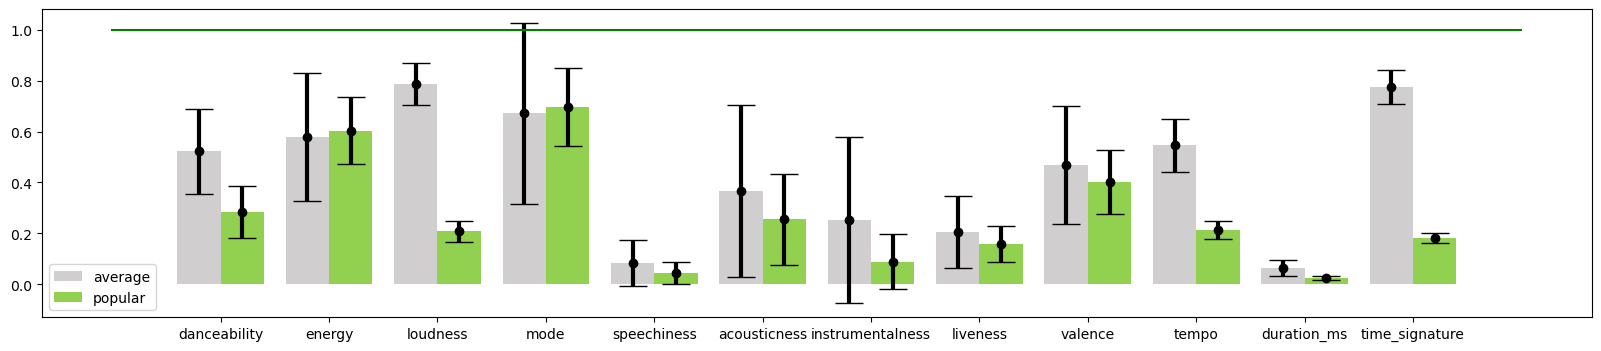

In [24]:
# plot data: average artist vs popular artist
X_axis = np.arange(len(data))
figure = plt.figure(figsize=(20, 4))#, sharey=True)
plt.bar(X_axis - 0.2, avg_attr_art, 0.4, label = 'average', color = '#D0CECE')
plt.bar(X_axis + 0.2, avg_attr_pop_art, 0.4, label = 'popular', color = '#92D050')
  
plt.errorbar(X_axis-0.2, avg_attr_art, yerr=std_attr_art, fmt='o', color='black',
             ecolor='black', elinewidth=3, capsize=10);
plt.errorbar(X_axis+0.2, avg_attr_pop_art, yerr=std_attr_pop_art, fmt='o', color='black',
             ecolor='black', elinewidth=3, capsize=10);
plt.plot(range(-1,len(data)+1),[1]*(len(data)+2),color="green")
plt.xticks(X_axis, data)
plt.legend()
plt.show()

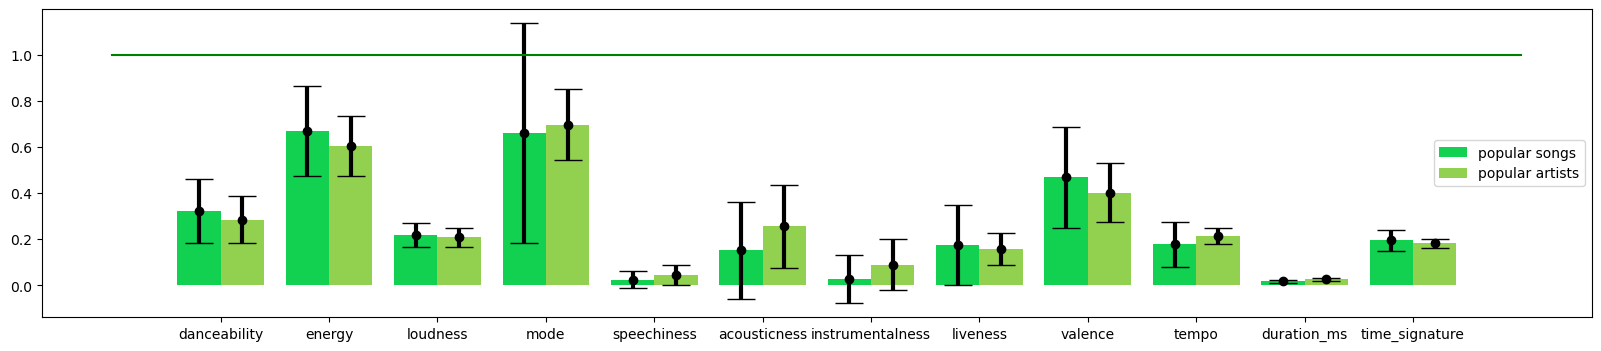

In [25]:
# plot data: popular artist vs popular songs
X_axis = np.arange(len(data))
figure = plt.figure(figsize=(20, 4))#, sharey=True)
plt.bar(X_axis - 0.2, avg_attr_pop, 0.4, label = 'popular songs', color = '#12D050')
plt.bar(X_axis + 0.2, avg_attr_pop_art, 0.4, label = 'popular artists', color = '#92D050')
  
plt.errorbar(X_axis-0.2, avg_attr_pop, yerr=std_attr_pop, fmt='o', color='black',
             ecolor='black', elinewidth=3, capsize=10);
plt.errorbar(X_axis+0.2, avg_attr_pop_art, yerr=std_attr_pop_art, fmt='o', color='black',
             ecolor='black', elinewidth=3, capsize=10);
plt.plot(range(-1,len(data)+1),[1]*(len(data)+2),color="green")
plt.xticks(X_axis, data)
plt.legend()
plt.show()

In [26]:
sc.stop()